# End-to-end tutorial: scikit-learn tutorial

This tutorial is an adaptation of the Machine Learning tutorial from Elite Data Science. The original tutorial is here:

https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn

Let us start with a few imports

In [1]:
! rm -rf /tmp/dds/tut_sklearn

In [2]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


Seting up the `dds` store:

In [3]:
import dds
dds.set_store("local",
              data_dir="/tmp/dds/tut_sklearn/data",
              internal_dir="/tmp/dds/tut_sklearn/internal")

In [4]:
import sklearn
import pandas as pd
import numpy as np
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import requests
import io
import json

We now add the import to the `dds` package. By default, the data will be stored in the temporary directory

In [5]:
import dds

The two internal directories (data and internal) are now there

Let's start with a familiar problem of accessing data from the internet. This piece of code will download a dataset, but with the additional twist that the dataset will be cached onto the local machine.

In [6]:
path_model = "/wine-quality/my_model"
path_model_stats = "/wine-quality/my_model_stats.json"

@dds.data_function("/wine-quality/raw")
def data():
    print("*** in _load_data ***")
    url = "https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv"
    x = requests.get(url=url, verify=False).content 
    return pd.read_csv(io.StringIO(x.decode('utf8')), sep=";")


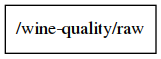

In [7]:
dds.eval(data, dds_export_graph="/tmp/2.png", dds_extra_debug=True, dds_stages=["analysis"])
from IPython.display import Image
Image("/tmp/2.png")

In [8]:
data().head(3)

*** in _load_data ***


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


Our complete pipeline. A few points are noteworthy:

 - the `_load_data` message does not appear: the data has already been loaded
 - note the use of `dds.keep` to keep multiple pieces of data that depend in an interconnected fashion to subset of the input dataset. The data is still loaded and split, but the ML model and scoring function will be evaluated once (try to rerun the cell below to see what happens)

In [9]:
def build_model(X_train, y_train):
    print("*** in build_model ***")
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=30))
    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt'],
                      'randomforestregressor__max_depth': [None, 5, 3]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    
    clf.fit(X_train, y_train)
    return clf
 
    
def model_stats(clf, X_test, y_test) -> str:
    print("*** in model_stats ***")
    pred = clf.predict(X_test)
    return json.dumps({
#         "r2_score": r2_score(y_test, pred), # uncomment me, see what happens
        "mse": mean_squared_error(y_test, pred)
    })
    
    
def pipeline():
    wine_data = data()
    y = wine_data.quality
    X = wine_data.drop('quality', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.15, 
                                                        random_state=123, 
                                                        stratify=y)
    clf = dds.keep(path_model, build_model, X_train, y_train)
    dds.keep(path_model_stats, model_stats, clf, X_test, y_test)
    print("*** done ***")


dds.eval(pipeline)

*** in build_model ***
*** in model_stats ***
*** done ***


Accessing the output. This can be done in 2 ways:

 - directly reading the files in its final destination in the store directory. The store in this notebook is configured to write data in `/tmp/dds/tut_sklearn/data`. Note that `my_model_stats.json` is directly readable as a text blob, as expected
 - loaded through its `dds` path, using `dds.load`. The latter is preferred because it is compatible with maintaining multiple data forks and branches without having to hardcode such branches.

In [10]:
%%sh
cat /tmp/dds/tut_sklearn/data/wine-quality/my_model_stats.json

{"mse": 0.32687499999999997}

In [11]:
dds.load("/wine-quality/my_model_stats.json")

'{"mse": 0.32687499999999997}'

Code update: updating the final `mode_stats` function simply rerun this part, not `build_model`.

In [12]:
def model_stats(clf, X_test, y_test) -> str:
    print("*** in model_stats ***")
    pred = clf.predict(X_test)
    return json.dumps({
        "r2_score": r2_score(y_test, pred), # now it was uncommented
        "mse": mean_squared_error(y_test, pred)
    })

dds.eval(pipeline)

*** in model_stats ***
*** done ***


In [13]:
%%sh
cat /tmp/dds/tut_sklearn/data/wine-quality/my_model_stats.json

{"r2_score": 0.49353059852051107, "mse": 0.32687499999999997}